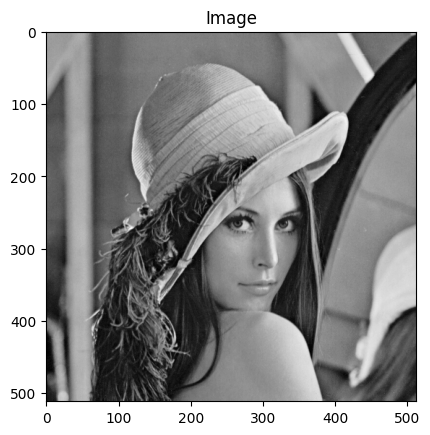

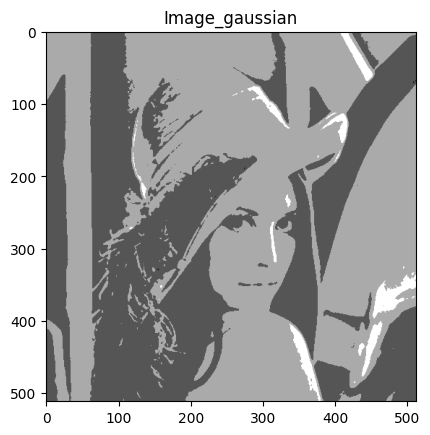

TypeError: Invalid shape (512,) for image data

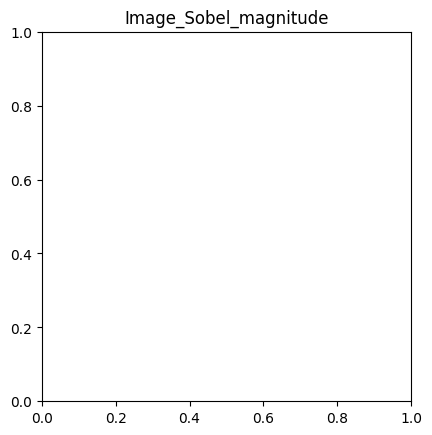

In [3]:
from scipy import ndimage
import cv2
import numpy as np
from scipy import ndimage
from matplotlib import pyplot as plt
import mpl_toolkits.axes_grid1 as axes_grid1
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, HTML
display(HTML("<style>div.output_scroll { height: 84em; }</style>"))
paths = ["Lenna.png", "Buildings.jpg", "Cart.jpg"]


def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g


def gradient(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.convolve(img, Kx)
    Iy = ndimage.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)

    return (G, theta)


def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180 / np.pi


    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z      

def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.4):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

def gradient(img):
    kernel1 = np.array([[0,0,0],[0,1,0],[0,0,0]])
    kernel2 = np.array([[0,0,0],[0,1,0],[0,0,0]])
    vertical = cv2.filter2D(img,-1,kernel1)
    horizontal = cv2.filter2D(img,-1,kernel2)
    edged_img = np.sqrt( np.square(horizontal) + np.square(vertical))
    return edged_img

kernel = [gaussian_kernel(3,11), gaussian_kernel(1,5) , gaussian_kernel(3,11)]    


j=0
for path in paths:
    Image = cv2.imread("Images/"+path, cv2.IMREAD_GRAYSCALE)
    #Step 1
    Image_gaussian = cv2.filter2D(Image,-1,kernel[j])
    #Step 2
    Image_Sobel = gradient(Image_gaussian)
    Image_Sobel_magnitude = Image_Sobel[0]
    Image_Sobel_angle = Image_Sobel[1]
    #Step 2.5
    Image_gradient = gradient(Image_gaussian)


    images = [Image, 
              Image_gaussian, 
              Image_Sobel_magnitude,  
              Image_Sobel_angle]
    titles = ["Image", 
              "Image_gaussian", 
              "Image_Sobel_magnitude",  
              "Image_Sobel_angle"]

    fig = plt.figure()
    i = 0
    for img in images:
        plt.title(titles[i])
        plt.imshow(img, cmap="gray")
        plt.show()
        i+=1

    #Step 4
    Image_nonMaxSupression = non_max_suppression(Image_Sobel_magnitude, Image_Sobel_angle)
    #Step 3
    Image_threshold = threshold(Image_nonMaxSupression)
    #Step 5
    Image_hysteresis = hysteresis(Image_threshold[0], Image_threshold[1])
    print(Image_threshold[1])


    images = [Image_nonMaxSupression, 
              Image_threshold[0], 
              Image_hysteresis]
    titles = ["Image_nonMaxSupression", 
              "Image_threshold", 
              "Image_hysteresis"]

    fig = plt.figure()
    i = 0
    for img in images:
        plt.title(titles[i])
        plt.imshow(img, cmap="gray")
        plt.show()
        i+=1
    
    j+=1

